# Signal Energy

Signal energy could be think as "signal strength". Mathematically, the autocorrelation of a signal could be interpreted as the strength of similarity of the signal in a manner consistent with the way we measure signal energy.

So, signal energy could be calculate as:

$E_x=\int_{-\infty}^{\infty} |x(t)|^2 \,dt = \frac{1}{2\pi} \int_{-\infty}^{\infty} |X(\omega)|^2 \,d\omega = \int_{-\infty}^{\infty} |X(2\pi f)|^2 \,df$ 

(aka. **Parseval's theorem** for the Fourier Transform)

This allows us to determine the signal energy from either the time-domain $x(t)$ or the frequency-domain $X(\omega)$ of the signal

If we consider the small band of frequencies $\Delta \omega$ ($\Delta \omega \rightarrow 0$) located at $\omega = k \Delta \omega$, we could calculate the energy $\Delta E_x$ as:

$\Delta E_x = \frac{1}{2\pi} |X(k\Delta \omega)|^2 \Delta \omega = |X(k\Delta\omega)|^2 \Delta f$

![](figures/energy-espectral-density.jpg)

$|X(\omega)|^2 \Delta f$ represents the energy contibuted by the components in a band of $\Delta f$ Hz.

Therefore, $|X(\omega)|^2$ is the **energy spectral density** (per unit bandwidth in Hz)

Let's do an example with Python:

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.fft import fft
from scipy.signal import welch

plt.style.use('dark_background')

In [22]:
fs = 250
L = 100
t = np.linspace(0,L,fs*L)
freq1 = 10
freq2 = 40
sig = np.sin(freq1*2*np.pi*t) + np.sin(freq2*2*np.pi*t) + 3*np.random.normal(0,1,fs*L)

energy = np.abs(fft(sig, fs))**2
freqs = np.linspace(0,fs/2,len(energy)//2)
energy = energy[:len(energy)//2]

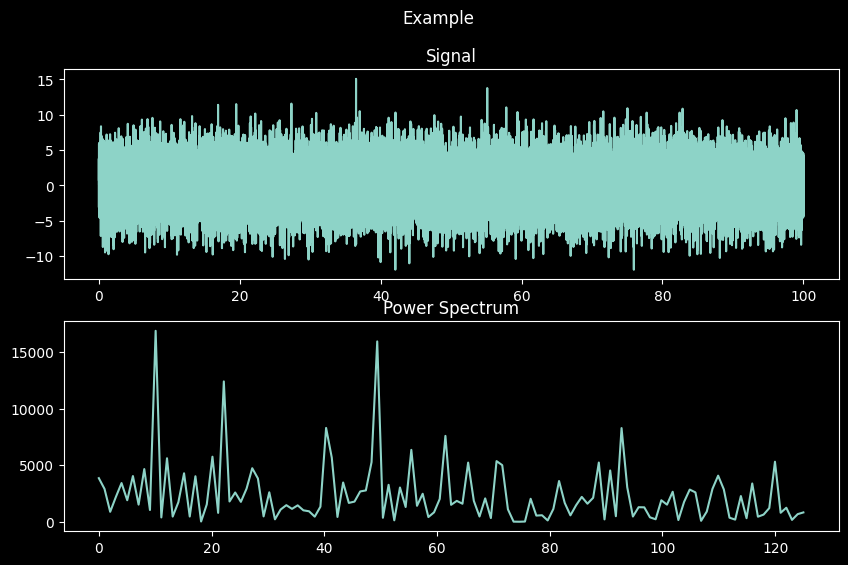

In [23]:
fig, axs = plt.subplots(2, figsize=(10,6))
fig.suptitle('Example')
axs[0].plot(t, sig)
axs[0].set_title('Signal')

axs[1].plot(freqs, energy)
axs[1].set_title('Power Spectrum')
plt.show()


# Signal Power

We can extend the idea of energy spectral density to:

$P_x = \lim_{T \to \infty} \frac{1}{T} \int_{-T/2}^{T/2} |x(t)|^2 \,dt =  \lim_{T \to \infty} \frac{1}{T} \int_{-\infty}^{\infty} |x_T(t)|^2 \,dt = \lim_{T \to \infty} \frac{E_{x_T}}{T}$

where $x_T(t) = x(t) \Pi(\frac{t}{T})$

So:

$P_x = \lim_{T \to \infty} \frac{1}{2\pi} \int_{-\infty}^{\infty} \frac{|X_T(\omega)|^2}{T} \,d\omega = \frac{1}{2\pi} \int_{-\infty}^{\infty} S_x(\omega) \,d\omega$

where $S_x(\omega)$ is the **power spectral density** (PSD) of $x(t)$ and it is defined by:

$S_x(\omega) = \lim_{T \to \infty} \frac{|X_T(\omega)|^2}{T}$

Unlike the Fourier, PSD does not contain phase information so it is not invertible (so it is not possible to reconstruct the signal from the PSD). However, PSD has a wider range of applicability and can be defined for signals that becomes from random processes (biosignals)

## Power Spectral Density

### Spectral Stimation de PSD

*Aim*: Find an stimator $\hat{S_x}$ from N timepoints of a signal $x(t)$ that is stationary in wide sense

There are 2 kinds of stimators:

1. **No-parametric**: The main is to reduce the variance of the periodogram but lower the frequency resolution

a)*Periodogram:* Modulus squared of the Discrete Time Fourier Transform


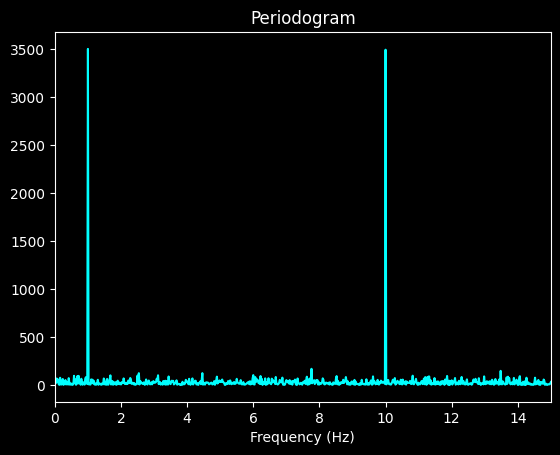

In [3]:
TFsig = fft(sig)
periodogram = np.abs(TFsig)**2 / len(TFsig)
f_p = np.linspace(0,fs//2,len(TFsig)//2)

plt.figure()
plt.plot(f_p, periodogram[:len(periodogram)//2], color='cyan')
plt.title('Periodogram')
plt.xlim(0,15)
plt.xlabel('Frequency (Hz)')
plt.show()

b) *Correlogram:* Discrete Time Fourier Transform of the autocorrelation stimator

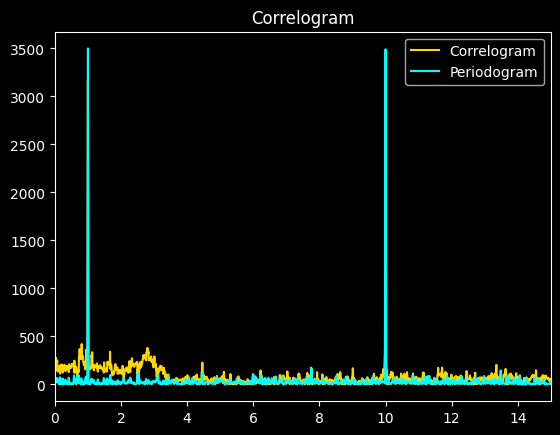

In [4]:
conv = np.convolve(sig,sig[::-1])
L = np.arange(-len(sig)+1,len(sig))
Rx = np.ndarray(shape=len(L), dtype=float)

# Unbiased correlation
for i in L:
    Rx[i] = conv[i]/(len(sig)-np.abs(L[i]))

Sx = np.abs(fft(Rx))/2
f_Sx = np.linspace(0,fs/2,len(Sx)//2)
plt.figure()
plt.plot(f_Sx,Sx[:len(Sx)//2],label='Correlogram', color='gold')
plt.plot(f_p, periodogram[:len(periodogram)//2], label='Periodogram', color='cyan')
plt.legend()
plt.xlim(0,15)
plt.title('Correlogram')
plt.show()

c) *Barlett Method:* Divide the signal in K parts and calculate the periodogram of each, the resulting stimator is the mean of them

50


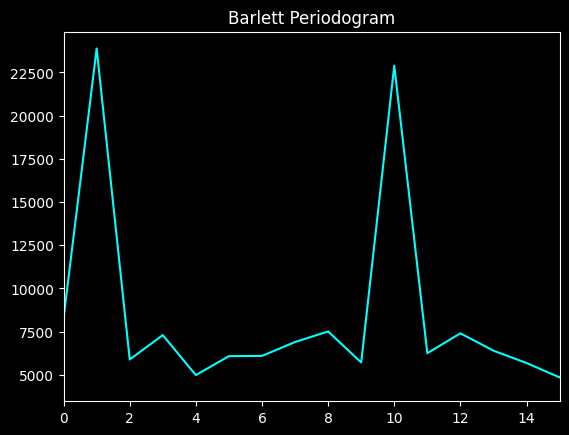

In [5]:
def barlett_periodogram(sig,L):
    n_segments = len(sig)//L
    print(n_segments)
    periodogram = np.zeros(L)
    for i in range(n_segments):
        segment=sig[i*L:(i+1)*L]
        periodogram += np.abs(fft(segment))**2
    periodogram = periodogram/n_segments
    return periodogram

plt.figure()
plt.plot(barlett_periodogram(sig,250), color='cyan')
plt.title('Barlett Periodogram')
plt.xlim(0,15)
plt.show()

d) *Welch Method:* Dicide the signal in K parts of length L that are overlapped, the resulting stimator is the mean of them

> See [Windowing.ipynb](Windowing.ipynb) for more information

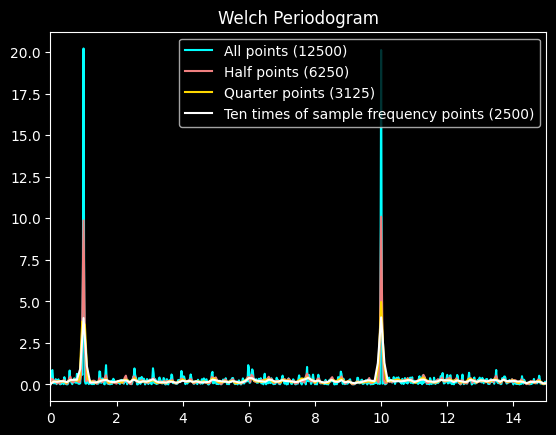

In [6]:
f_1, we_1 = welch(sig, fs=fs, nperseg=len(sig))
f_2, we_2 = welch(sig, fs=fs, nperseg=len(sig)//2)
f_3, we_3 = welch(sig, fs=fs, nperseg=len(sig)//4)
f_4, we_4 = welch(sig, fs=fs, nperseg=10*fs)

plt.figure()
plt.plot(f_1, we_1, color='cyan', label=f'All points ({len(sig)})')
plt.plot(f_2, we_2, color='lightcoral', label=f'Half points ({len(sig)//2})')
plt.plot(f_3, we_3, color='gold',label=f'Quarter points ({len(sig)//4})')
plt.plot(f_4, we_4, color='white',label=f'Ten times of sample frequency points ({10*fs})')
plt.title('Welch Periodogram')
plt.xlim(0,15)
plt.legend()
plt.show()

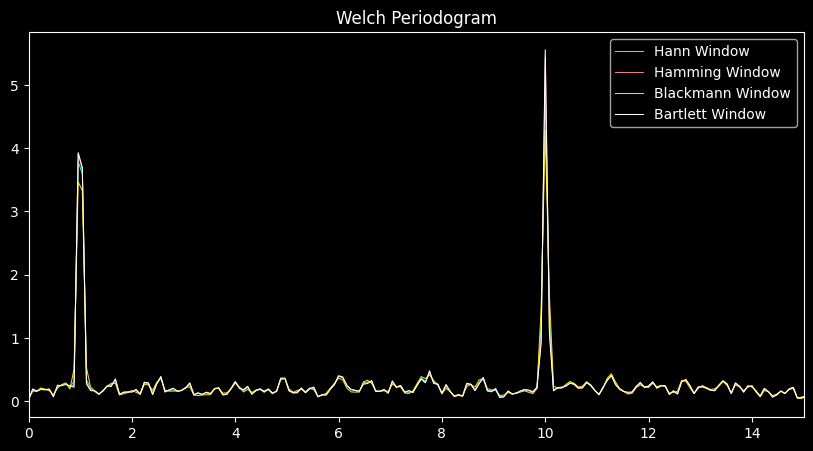

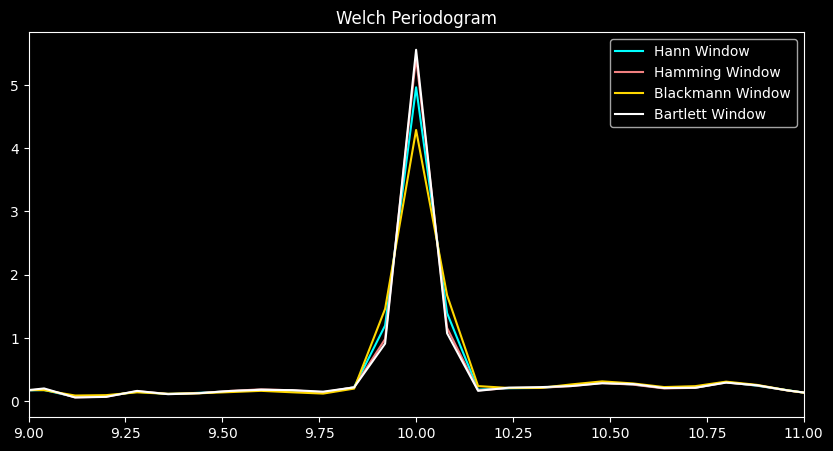

In [7]:
f_1, we_1 = welch(sig, fs=fs, nperseg=len(sig)//4, window='hann')
f_2, we_2 = welch(sig, fs=fs, nperseg=len(sig)//4, window='hamming')
f_3, we_3 = welch(sig, fs=fs, nperseg=len(sig)//4, window='blackman')
f_4, we_4 = welch(sig, fs=fs, nperseg=len(sig)//4, window='bartlett')


plt.figure(figsize=(10,5))
plt.plot(f_1, we_1, color='cyan', label=f'Hann Window',linewidth=0.75)
plt.plot(f_2, we_2, color='lightcoral', label=f'Hamming Window',linewidth=0.75)
plt.plot(f_3, we_3, color='gold',label=f'Blackmann Window',linewidth=0.75)
plt.plot(f_4, we_4, color='white',label=f'Bartlett Window', linewidth=0.75)
plt.title('Welch Periodogram')
plt.xlim(0,15)
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(f_1, we_1, color='cyan', label=f'Hann Window')
plt.plot(f_2, we_2, color='lightcoral', label=f'Hamming Window')
plt.plot(f_3, we_3, color='gold',label=f'Blackmann Window')
plt.plot(f_4, we_4, color='white',label=f'Bartlett Window')
plt.title('Welch Periodogram')
plt.xlim(9,11)
plt.legend()
plt.show()

<span style="color:#00FF80">**Difference between Hann and Hamming**</span>

<span style="color:#00FF80">The differences are a few.</span>

<span style="color:#00FF80">Hamming window is 92% Hann window and 8% rectangular in order to reduce the height of the maximum side lobe.</span>

<span style="color:#00FF80">Hann window is a complementary window, that is the latter half of the window of one frame adds to the first half of the following frame to 1. For analysis, the property of being complementary is not important, but for synthesis or reconstruction is salient.</span>



2. **Parametric:** Express the system as a differential equation $y{n} + \sum_{i=1}^{K} a_i y[n-i] = \sum_{j=0}^{L} x[n-j]$
    * *AR processes:* $a_i = 0 \rightarrow y[n] = \sum_{j=0}^{L} b_k x[n-j]$
    * *MA processes:* $b_j = 0 \rightarrow y[n] + \sum_{i=1}^{K} a_i y[n-i] = x[n]$

# About bandpower of interest of the signal

In [8]:
import mne
from  scipy import integrate

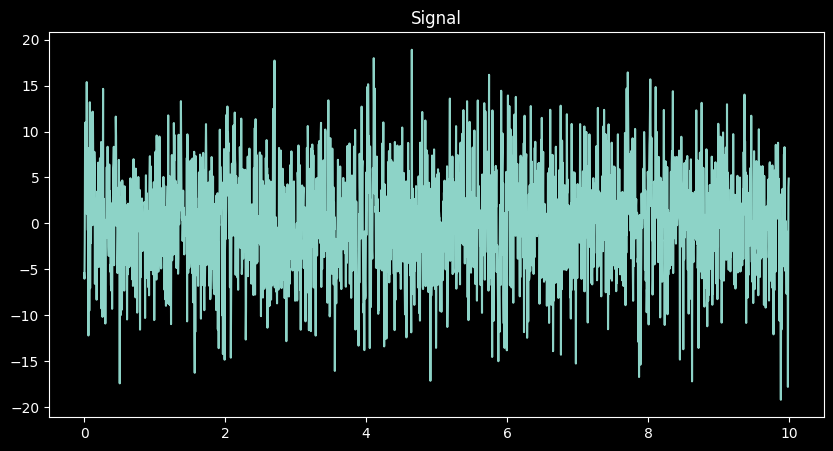

In [9]:
fs = 250
L = 30*fs
t = np.linspace(0,L,fs*L) 
# delta and 
sig = 5*np.random.normal(0,1,fs*L) + np.sin(2*np.pi*t) + np.sin(2.5*2*np.pi*t) + np.sin(3*2*np.pi*t) + np.sin(9*2*np.pi*t) + np.sin(9.5*2*np.pi*t) + np.sin(10*2*np.pi*t) + np.sin(10.5*2*np.pi*t) + np.sin(11*2*np.pi*t) + np.sin(12*2*np.pi*t)

plt.figure(figsize=(10,5))
plt.title('Signal')
plt.plot(t[:10*fs],sig[:10*fs])
plt.show()

## Welch

Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


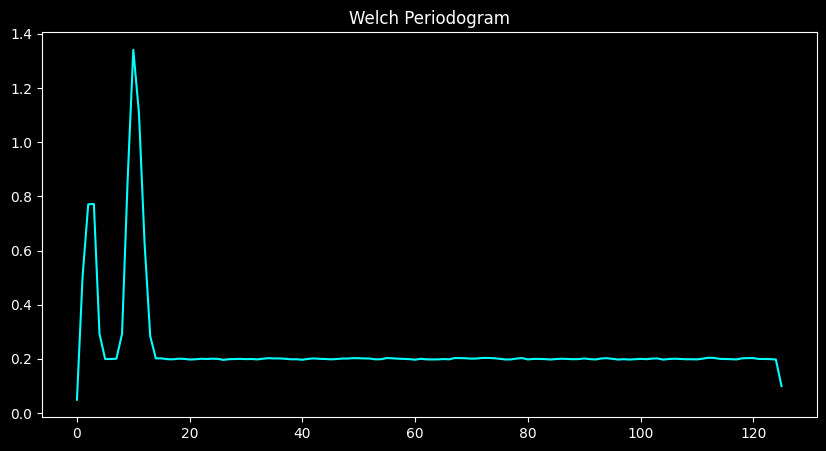

In [10]:
nperseg=int(fs)
nfft = nperseg
noverlap=int(nperseg/2)
psd_all, freq_all = mne.time_frequency.psd_array_welch(sig, 
                                                sfreq=fs, 
                                                n_fft=nfft, 
                                                n_per_seg=nperseg, 
                                                window='hann',
                                                n_overlap=noverlap,)

plt.figure(figsize=(10,5))
plt.plot(freq_all, psd_all, 'cyan')
plt.title('Welch Periodogram')
plt.show()

In [11]:
def set_freqs(rythm):
    if rythm == 'band1':
        return [0.5, 1]
    elif rythm == 'band2':
        return [1, 4]
    elif rythm == 'band3':
        return [4, 8]
    elif rythm == 'band4':
        return [8, 13]
    elif rythm == 'band5':
        return [15, 30]
    elif rythm == 'band6':
        return [30, 60]

In [12]:
nperseg=int(fs)
nfft = nperseg
noverlap=int(nperseg/2)
dic = {}
for r in ['band1', 'band2', 'band3', 'band4', 'band5', 'band6']:
    freqs = set_freqs(r)

    psd, freq = mne.time_frequency.psd_array_welch(sig, 
                                                    sfreq=fs, 
                                                    n_fft=nfft, 
                                                    n_per_seg=nperseg, 
                                                    window='hann',
                                                    n_overlap=noverlap,
                                                    fmin=freqs[0], fmax=freqs[1])
    auc = integrate.simpson(psd, freq)/(freqs[1]-freqs[0])

    dic[r] = auc

print(dic)

Effective window size : 1.000 (s)
Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Effective window size : 1.000 (s)
Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Effective window size : 1.000 (s)
Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'band1': 0.0, 'band2': 0.6676907530828015, 'band3': 0.21552881705658736, 'band4': 0.8606714432701154, 'band5': 0.19941203943586328, 'band6': 0.2003985614487632}


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Order bandpower in decrescending order:

In [13]:
dict(sorted(dic.items(), key=lambda item: item[1], reverse=True))

{'band4': 0.8606714432701154,
 'band2': 0.6676907530828015,
 'band3': 0.21552881705658736,
 'band6': 0.2003985614487632,
 'band5': 0.19941203943586328,
 'band1': 0.0}

**Relative power**

In [14]:
nperseg=int(fs)
nfft = nperseg
noverlap=int(nperseg/2)

total_psd, total_freq = mne.time_frequency.psd_array_welch(sig, 
                                                sfreq=fs, 
                                                n_fft=nfft, 
                                                n_per_seg=nperseg, 
                                                window='hann',
                                                n_overlap=noverlap)

total_auc = integrate.simpson(total_psd, total_freq)

dic = {}

for r in ['band1', 'band2', 'band3', 'band4', 'band5', 'band6']:
    freqs = set_freqs(r)

    psd, freq = mne.time_frequency.psd_array_welch(sig, 
                                                    sfreq=fs, 
                                                    n_fft=nfft, 
                                                    n_per_seg=nperseg, 
                                                    window='hann',
                                                    n_overlap=noverlap,
                                                    fmin=freqs[0], fmax=freqs[1])
    auc = integrate.simpson(psd, freq)/(freqs[1]-freqs[0])/total_auc

    dic[r] = auc

print(dic)

Effective window size : 1.000 (s)
Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Effective window size : 1.000 (s)
Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'band1': 0.0, 'band2': 0.022415412818908968, 'band3': 0.007235636237866832, 'band4': 0.028894073511234256, 'band5': 0.006694571048614042, 'band6': 0.006727690120687443}


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [15]:
dict(sorted(dic.items(), key=lambda item: item[1], reverse=True))

{'band4': 0.028894073511234256,
 'band2': 0.022415412818908968,
 'band3': 0.007235636237866832,
 'band6': 0.006727690120687443,
 'band5': 0.006694571048614042,
 'band1': 0.0}

# Multitaper

Multitaper is a spectral analysis method first developed by David J. Thompson in 1982 in order to overcome some of the limitations of the classical spectral estimation techniques about Fourier Transform. It provides a more robust spectral estimation than the classical and Welch's periodograms, by combining the advantages of the two methods: high frequency resolution and low variance.

Multitaper method starts by filtering the original signal with a set of optimal bandpass filter, called Slepian sequences (or DPSS). This filtering is done by convoluting the original signal with the Slepian sequences. Second, a classic periodogram is calculated for each of these new filtered (or "tapered") data and the final spectrum is then obtained by averaging over all the resulting periodogram. The real strength of the multitaper method comes from the fact that the Slepian sequences are orthogonal to all others and therefore the tapered signals provide statistically independent estimates of the underlying spectrum. In other words, each filtered signal will highlight one specific aspect of the spectral content of the signal.

C:\Users\ayvazquez\AppData\Local\Temp\ipykernel_6656\4253037331.py:1: RuntimeWarning: Could not properly use low_bias, keeping lowest-bias taper
  psd_all, freq_all = mne.time_frequency.psd_array_multitaper(sig, fs, adaptive=True,normalization='full', verbose=0)
C:\Users\ayvazquez\AppData\Local\Temp\ipykernel_6656\4253037331.py:1: RuntimeWarning: Not adaptively combining the spectral estimators due to a low number of tapers (1 < 3).
  psd_all, freq_all = mne.time_frequency.psd_array_multitaper(sig, fs, adaptive=True,normalization='full', verbose=0)


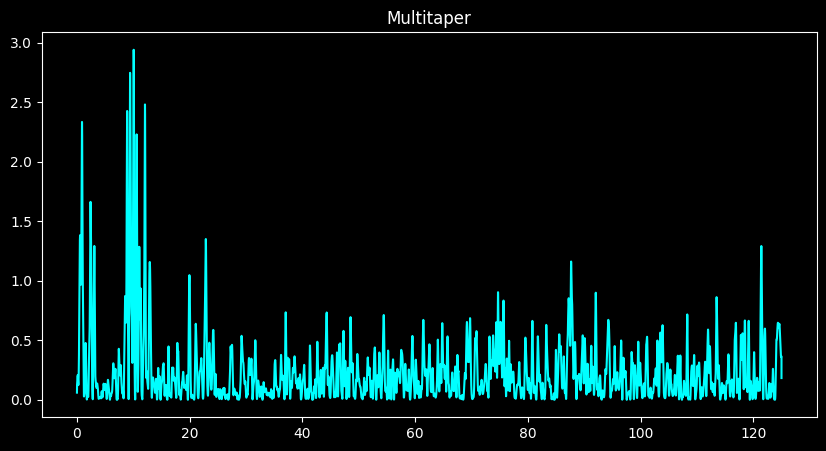

In [16]:
psd_all, freq_all = mne.time_frequency.psd_array_multitaper(sig, fs, adaptive=True,normalization='full', verbose=0)
plt.figure(figsize=(10,5))
plt.plot(freq_all, psd_all, 'cyan')
plt.title('Multitaper')
plt.show()

The results are very close to the one obtained using Welch's method. This should remain true as long as your data are not too noisy. However, if you are working with noisy data, the multitaper method will always provide a much more robust spectral estimation than Welch's.

The multitaper is more computationally intensive than other methods. This is definitely something that you may want to consider when deciding which method to use.

Second, although the multitaper methods always provide a more robust spectral estimation, choosing which technique one should use depends on the data at hands. For example, if you have clean data acquired on young healthy individuals, there's a good chance that the multitaper spectral estimation will not differ that much from the Welch's estimate. Furthermore, the Welch's method is probably the most used spectral estimation technique to this day and is quite intuitive to understand. By contrast, the multitaper is a relatively new method that is conceptually harder to grasp.